<a href="https://colab.research.google.com/github/marathomas/meerkat/blob/master/05_Comparison_to_traditional.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Embedding in traditional features

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import pandas as pd
import sys
os.system('pip install "librosa==0.7.1"')
import librosa
import numpy as np
import statistics
import matplotlib.pyplot as plt
import pickle
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.legend import Legend
from matplotlib.animation import FuncAnimation
from matplotlib import animation, rc, gridspec
import matplotlib
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import umap
from scipy.stats import zscore
from sklearn import metrics
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import NearestNeighbors
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.legend import Legend
from matplotlib.animation import FuncAnimation
from matplotlib import animation, rc, gridspec
import matplotlib
import seaborn as sns
from matplotlib.text import Annotation
from mpl_toolkits.mplot3d.proj3d import proj_transform
from mpl_toolkits.mplot3d.axes3d import Axes3D
import scipy
from scipy.spatial.distance import euclidean as euclid
from scipy.spatial import distance_matrix
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA


PROJECT_PATH = "/content/drive/My Drive/meerkat/" 
FIGURES = PROJECT_PATH+"figures/"
DATA = PROJECT_PATH+"data/"

os.chdir(PROJECT_PATH)

# Load datasets

In [3]:
df_name = '2020-09-20_embedding_denoised_melspectro_focal_focal'
df = pd.read_pickle(DATA+'df_denoised_balanced')
df = df[df.nonfocal_yn == 'n'] # for focal
df.reset_index(inplace=True)

In [3]:
features = pd.read_csv(PROJECT_PATH+"data/frants/mara_features_allSNR.csv")

In [4]:
features.head(3)

,CALL_INDEX,Call_Type,Energy_Duration,Spectral_Entropy,Temporal_Entropy,Cepstral_Peak_Prominence,Centroid_Frequency,Peak_Frequency,lower_frequency_10dB,Upper_Frequency_10dB,Bandwidth_RMS,Bandwidth_10dB,F0_mean,F0_start,F0_mid,F0_end,SNR
0,0,sn,0.034750,4.824401,0.856071,22.450264,1380.572976,1296.8750,1195.3125,1398.4375,399.863732,203.125,1290.178571,1296.875,1296.8750,1273.4375,8.456472
1,1,al,0.028500,5.877919,0.848490,20.901762,1218.884450,1289.0625,312.5000,1437.5000,562.881075,1125.000,1308.593750,1359.375,1335.9375,1265.6250,-3.195684
2,2,al,0.039375,4.822398,0.915894,19.453461,1407.414980,1203.1250,1078.1250,1312.5000,584.475114,234.375,1208.007812,1171.875,1203.1250,1242.1875,17.318290


In [6]:
all_indices = features.CALL_INDEX

In [8]:
3 in all_indices

True

Check for NA vals

In [5]:
features.isnull().sum()

CALL_INDEX                  0
Call_Type                   0
Energy_Duration             0
Spectral_Entropy            0
Temporal_Entropy            0
Cepstral_Peak_Prominence    0
Centroid_Frequency          0
Peak_Frequency              0
lower_frequency_10dB        0
Upper_Frequency_10dB        0
Bandwidth_RMS               0
Bandwidth_10dB              0
F0_mean                     0
F0_start                    0
F0_mid                      0
F0_end                      0
SNR                         0
dtype: int64

# Check if reasonable

Boxplot for different variables based on calltype

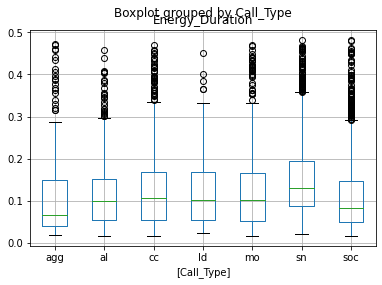

In [16]:
boxplot = features[['Call_Type', 'Energy_Duration']].boxplot(by='Call_Type')

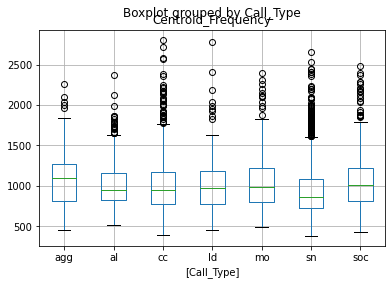

In [17]:
boxplot = features[['Call_Type', 'Centroid_Frequency']].boxplot(by='Call_Type')

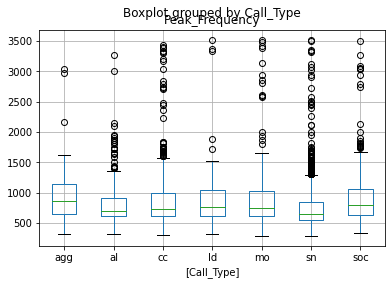

In [18]:
boxplot = features[['Call_Type', 'Peak_Frequency']].boxplot(by='Call_Type')

# Dimensionality reduction

In [9]:
embedding_dict = {}

In [10]:
def plotly_viz(method):

  embedding = embedding_dict[method]
  x, y, z = embedding[:,0], embedding[:,1], embedding[:,2] 
  scat_labels = labels
  labeltypes = sorted(list(set(scat_labels)))

  # makes colors same as AVGN visualization
  pal = sns.color_palette("Set2", n_colors=len(labeltypes))
  color_dict = dict(zip(labeltypes, pal))
  c = [color_dict[val] for val in scat_labels]

  fig = go.Figure(data=[go.Scatter3d(x=x, y=y, z=z,
                                    mode='markers',
                                    hovertext = labels,
                                    marker=dict(
                                        size=4,
                                        color=c,                # set color to an array/list of desired values
                                        opacity=0.8
                                        ))])

  fig.update_layout(scene = dict(
                      xaxis_title=method+'1',
                      yaxis_title=method+'2',
                      zaxis_title=method+'3'),
                      width=700,
                      margin=dict(r=20, b=10, l=10, t=10))

  return fig

#plotly_viz("UMAP").show()

## Prepare input data

choose columns to drop

In [10]:
columns_to_drop = ['CALL_INDEX', 'Call_Type', 'SNR', 'F0_start', 'F0_mid', 'F0_end']

Choose data

In [ ]:
# A) Full dataset
data = features.drop(columns=columns_to_drop)
labels = features.Call_Type

In [11]:
# B) reduce set to only high quality (signal to noise > 10 dB)
data = features.loc[features.SNR>10,]
labels = data.Call_Type
data = data.drop(columns=columns_to_drop)
data.shape

(5306, 11)

In [12]:
data.head(3)

,Energy_Duration,Spectral_Entropy,Temporal_Entropy,Cepstral_Peak_Prominence,Centroid_Frequency,Peak_Frequency,lower_frequency_10dB,Upper_Frequency_10dB,Bandwidth_RMS,Bandwidth_10dB,F0_mean
2,0.039375,4.822398,0.915894,19.453461,1407.414980,1203.125,1078.1250,1312.5000,584.475114,234.3750,1208.007812
3,0.032625,3.931041,0.793763,21.235393,1312.126084,1296.875,1195.3125,1414.0625,161.830896,218.7500,1295.572917
4,0.041625,4.610101,0.953889,16.560427,864.562632,718.750,593.7500,1476.5625,347.535126,882.8125,719.238281


z-transform

In [13]:
data_z = StandardScaler().fit_transform(data)

In [ ]:
data = np.asarray(data)

## UMAP

In [50]:
#UMAP
reducer = umap.UMAP(low_memory=True, n_components = 10, min_dist=0)
embedding_dict['UMAP'] =  reducer.fit_transform(data_z)

In [51]:
plotly_viz("UMAP").show()

## tSNE

In [ ]:
model = TSNE(n_components=3, init='pca', random_state=0, perplexity=data.shape[0]/100, learning_rate=round(data.shape[0]/12))
embedding_dict['tSNE'] = model.fit_transform(data_z) 

plotly_viz('tSNE').show()

## PCA

In [ ]:
p = PCA(n_components=10, random_state=728)
p.fit(np.transpose(data))
embedding_dict['PCA'] = np.transpose(p.components_)

plotly_viz("PCA").show()

# Visualization

In [ ]:
def plotly_viz(method):

  embedding = embedding_dict[method]
  x, y, z = embedding[:,0], embedding[:,1], embedding[:,2] 
  scat_labels = labels
  labeltypes = sorted(list(set(scat_labels)))

  # makes colors same as AVGN visualization
  pal = sns.color_palette("Set2", n_colors=len(labeltypes))
  color_dict = dict(zip(labeltypes, pal))
  c = [color_dict[val] for val in scat_labels]

  fig = go.Figure(data=[go.Scatter3d(x=x, y=y, z=z,
                                    mode='markers',
                                    hovertext = labels,
                                    marker=dict(
                                        size=4,
                                        color=c,                # set color to an array/list of desired values
                                        opacity=0.8
                                        ))])

  fig.update_layout(scene = dict(
                      xaxis_title=method+'1',
                      yaxis_title=method+'2',
                      zaxis_title=method+'3'),
                      width=700,
                      margin=dict(r=20, b=10, l=10, t=10))

  return fig

plotly_viz("UMAP").show()

# Evaluate embedding

In [52]:
embedding = embedding_dict['UMAP']

In [53]:
k=5

# Find k nearest neighbors
nbrs = NearestNeighbors(metric='euclidean',n_neighbors=k+1, algorithm='brute').fit(embedding)
distances, indices = nbrs.kneighbors(embedding)

# need to remove the first neighbor, because that is the datapoint itself
indices = indices[:,1:]  
distances = distances[:,1:]

In [54]:
nn_stats_dict = {}
calltypes = sorted(list(set(labels)))
labels = np.asarray(labels)

for calltype in calltypes:
  call_indices = np.asarray(np.where(labels==calltype))[0]
  calltype_counts = np.zeros((call_indices.shape[0],len(calltypes)))

  for i,ind in enumerate(call_indices):
    nearest_neighbors = indices[ind]
    for neighbor in nearest_neighbors:
      neighbor_label = labels[neighbor]
      calltype_counts[i,np.where(np.asarray(calltypes)==neighbor_label)[0][0]] += 1 
  nn_stats_dict[calltype] = calltype_counts

In [55]:
# Overall frequencies
overall = np.zeros((len(calltypes)))
for i,calltype in enumerate(calltypes):
  sub_emb = embedding[labels==calltype,:]
  overall[i] = sub_emb.shape[0] 

overall = (overall/np.sum(overall))*100


stats_tab = np.zeros((len(calltypes),len(calltypes)))
stats_tab_norm = np.zeros((len(calltypes),len(calltypes)))

for i, calltype in enumerate(calltypes):
  stats = nn_stats_dict[calltype]
  stats_tab[i,:] = (np.mean(stats,axis=0)/k)*100
  stats_tab_norm[i,:] = ((np.mean(stats,axis=0)/k)*100)/overall

stats_tab = pd.DataFrame(stats_tab)
stats_tab_norm = pd.DataFrame(stats_tab_norm)

stats_tab.loc[len(stats_tab)] = overall
#stats_tab_norm.loc[len(stats_tab_norm)] = overall/overall

stats_tab.columns = calltypes
stats_tab.index = calltypes+['overall']

stats_tab_norm.columns = calltypes
stats_tab_norm.index = calltypes
stats_tab_norm = np.log2(stats_tab_norm)

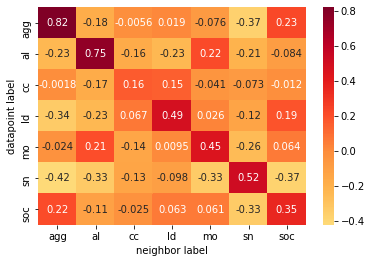

In [57]:
ax=sns.heatmap(stats_tab_norm, center=0, annot=True, cmap='YlOrRd')
plt.xlabel("neighbor label")
plt.ylabel("datapoint label")
plt.show()

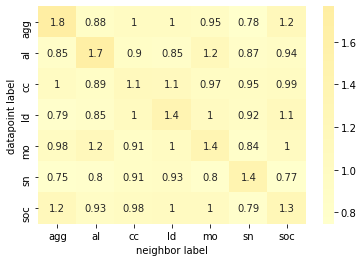

In [56]:
# for easier interpretation: fold likelihood (x times more likely to find label in neighborhood
# than expected by chance)

ax=sns.heatmap(np.power(2,stats_tab_norm), center=5, annot=True, cmap='YlOrRd')
plt.xlabel("neighbor label")
plt.ylabel("datapoint label")
plt.show()

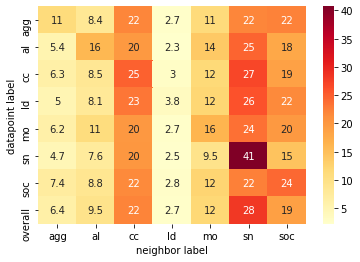

In [58]:
ax=sns.heatmap(stats_tab, annot=True, cmap='YlOrRd')
plt.xlabel("neighbor label")
plt.ylabel("datapoint label")
plt.show()